In [2]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split , StratifiedKFold
import numpy as np
import cv2
import os
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, concatenate, Dropout,ReLU
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [3]:
df = pd.read_csv('Dataset.csv')
df

,id,log-sigma-1-0-mm-3D_glrlm_GrayLevelNonUniformity,log-sigma-1-0-mm-3D_ngtdm_Coarseness,minor_axis_length,area,log-sigma-1-0-mm-3D_gldm_DependenceNonUniformity,log-sigma-2-0-mm-3D_ngtdm_Coarseness,log-sigma-2-0-mm-3D_gldm_DependenceNonUniformity,log-sigma-2-0-mm-3D_glrlm_GrayLevelNonUniformity,wavelet-H_ngtdm_Coarseness,...,wavelet-H_glcm_JointEntropy,wavelet-H_glrlm_GrayLevelNonUniformityNormalized,log-sigma-2-0-mm-3D_glrlm_GrayLevelNonUniformityNormalized,log-sigma-1-0-mm-3D_glrlm_HighGrayLevelRunEmphasis,log-sigma-2-0-mm-3D_glcm_MCC,LBP_hist_bin_7,log-sigma-1-0-mm-3D_gldm_HighGrayLevelEmphasis,label,unexplained_infertility,previous_miscarriages
0,1,4809.535706,0.000247,198.625804,34583,12731.61441,0.000467,13018.03444,2687.906126,0.000138,...,3.863600,0.275603,0.205812,110.158185,0.839618,0.054680,111.058150,0,0,0
1,2,4460.623751,0.000284,193.191790,32053,11900.13194,0.000526,11521.54435,2826.917297,0.000162,...,4.119202,0.252179,0.187636,72.062320,0.853366,0.063489,72.682151,0,0,0
2,3,4925.207181,0.000240,199.327172,34346,13081.91446,0.000431,13580.04041,2784.541071,0.000135,...,3.434695,0.314459,0.231505,56.084546,0.845357,0.060094,56.346329,0,0,0
3,4,4664.352654,0.000257,195.713530,34131,12645.47833,0.000490,12945.91348,2610.770111,0.000141,...,3.599379,0.297244,0.199265,72.034173,0.868814,0.058949,72.831414,0,0,0
4,5,4420.923359,0.000271,196.147021,32842,12027.18696,0.000530,11766.90250,2474.527556,0.000152,...,3.922065,0.272541,0.179913,72.190030,0.855325,0.061050,72.673284,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,124,4568.094233,0.000288,219.654077,39686,14367.67661,0.000472,14273.76697,3055.538006,0.000139,...,3.333863,0.321830,0.175555,90.434190,0.869936,0.069445,90.857481,1,0,1
124,125,4664.626825,0.000275,218.066669,39662,14590.95351,0.000430,14823.92587,3175.472188,0.000136,...,3.076035,0.349690,0.193674,72.112061,0.883472,0.069538,72.611845,1,1,0
125,126,5203.038054,0.000240,229.486021,41192,14904.76695,0.000434,14441.28705,3412.583833,0.000128,...,4.018386,0.262754,0.175031,72.478047,0.846720,0.072174,72.935619,1,0,1
126,127,5362.058473,0.000235,227.372063,40050,14744.51181,0.000405,14445.17743,3592.559575,0.000131,...,4.098497,0.255446,0.195726,110.253146,0.847308,0.059026,110.723695,1,1,0


In [4]:
tabular_data = df.drop(['id' , 'label'] , axis=1)
labels = df['label']

In [5]:
Scaler = StandardScaler()
Scaled_tabular_data = Scaler.fit_transform(tabular_data)

In [6]:
image_folder = r"C:\Users\User\Desktop\Junior\Machine\Machine Project\Ultrasound-Based-Classification-of-Uterine-Abnormalities\data\images"
image_list = []

for image_id in df['id']:
    img_name = f"{int(image_id):04d}.jpg"
    

    img_path = os.path.join(image_folder, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f"Image not found: {img_path}")
        continue

    img = img/255.0

    img= img[..., np.newaxis]
    image_list.append(img)

x_img = np.array(image_list, dtype=np.float32)
print(f"Image data shape: {x_img.shape}")


Image data shape: (128, 256, 256, 1)


In [7]:
X_img_3ch = np.repeat(x_img, 3, axis=-1)

X_tab_trainval, X_tab_test, X_img_trainval, X_img_test, y_trainval, y_test = train_test_split(
    tabular_data, x_img, labels, test_size=0.3, stratify=labels, random_state=42
)

print("--- Tabular Data ---")
print(f"TrainVal Tabular: {X_tab_trainval.shape}") 
print(f"Test Tabular:     {X_tab_test.shape}")


print("\n--- Image Data ---")
print(f"TrainVal Images:  {X_img_trainval.shape}") 
print(f"Test Images:      {X_img_test.shape}")


--- Tabular Data ---
TrainVal Tabular: (89, 400)
Test Tabular:     (39, 400)

--- Image Data ---
TrainVal Images:  (89, 256, 256, 1)
Test Images:      (39, 256, 256, 1)


In [ ]:

vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
vgg_base.trainable = False  


image_input = Input(shape=(256, 256, 3))
x = vgg_base(image_input)
x = GlobalAveragePooling2D()(x) 
cnn_feature_extractor = Model(inputs=image_input, outputs=x)



VGG16 Feature Extractor Ready (No training required)


In [ ]:



cv_train_acc = []
cv_val_acc = []
cv_val_auc = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(skf.split(X_tab_trainval, y_trainval), 1):

    print(f"\n===== Fold {fold} =====")

   
    X_tab_train = X_tab_trainval.iloc[train_idx]
    X_tab_val   = X_tab_trainval.iloc[val_idx]

    X_img_train = X_img_3ch[train_idx]
    X_img_val   = X_img_3ch[val_idx]

    y_train = y_trainval.iloc[train_idx]
    y_val   = y_trainval.iloc[val_idx]

    print(f"DEBUG: Fold {fold} Shapes:")
    print(f"  - Training samples: {X_img_train.shape[0]}")
    print(f"  - Validation samples: {X_img_val.shape[0]}")
   
    train_cnn = cnn_feature_extractor.predict(preprocess_input(X_img_train * 255.0), verbose=0)
    val_cnn = cnn_feature_extractor.predict(preprocess_input(X_img_val * 255.0), verbose=0)

    tab_scaler = StandardScaler()
    X_tab_train = tab_scaler.fit_transform(X_tab_train)
    X_tab_val   = tab_scaler.transform(X_tab_val)


 
    X_train_comb = np.concatenate([X_tab_train, train_cnn], axis=1)
    X_val_comb   = np.concatenate([X_tab_val, val_cnn], axis=1)

    #PCA
    pca = PCA(n_components=0.95) 
    X_train_pca = pca.fit_transform(X_train_comb)
    X_val_pca   = pca.transform(X_val_comb)
    print(f"Features reduced from {X_train_comb.shape[1]} to {X_train_pca.shape[1]}")

    comb_scaler = StandardScaler()
    X_train_scaled = comb_scaler.fit_transform(X_train_pca)
    X_val_scaled   = comb_scaler.transform(X_val_pca)

  
    svm = SVC(kernel='rbf', C=10, gamma=0.001 , class_weight='balanced')
    svm.fit(X_train_scaled, y_train)

    
    train_pred = svm.predict(X_train_scaled)
    train_acc = accuracy_score(y_train, train_pred)
    cv_train_acc.append(train_acc)

  
    val_pred = svm.predict(X_val_scaled)
    val_acc = accuracy_score(y_val, val_pred)
    cv_val_acc.append(val_acc)

    val_scores = svm.decision_function(X_val_scaled)
    fpr, tpr, _ = roc_curve(y_val, val_scores)
    val_auc = auc(fpr, tpr)
    cv_val_auc.append(val_auc)

    print(f"Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f} | Val ROC-AUC: {val_auc:.3f}")

# Final Cross-Validation Summary
print("\n" + "="*25)
print(f"Mean CV Train Accuracy: {np.mean(cv_train_acc):.3f}")
print(f"Mean CV Val Accuracy:   {np.mean(cv_val_acc):.3f}")
print(f"Mean CV Val ROC-AUC:    {np.mean(cv_val_auc):.3f}")


===== Fold 1 =====
DEBUG: Fold 1 Shapes:
  - Training samples: 71
  - Validation samples: 18
Features reduced from 912 to 47
Train Acc: 0.972 | Val Acc: 0.778 | Val ROC-AUC: 0.852

===== Fold 2 =====
DEBUG: Fold 2 Shapes:
  - Training samples: 71
  - Validation samples: 18
Features reduced from 912 to 46
Train Acc: 0.972 | Val Acc: 0.778 | Val ROC-AUC: 0.840

===== Fold 3 =====
DEBUG: Fold 3 Shapes:
  - Training samples: 71
  - Validation samples: 18
Features reduced from 912 to 46
Train Acc: 0.986 | Val Acc: 0.722 | Val ROC-AUC: 0.712

===== Fold 4 =====
DEBUG: Fold 4 Shapes:
  - Training samples: 71
  - Validation samples: 18
Features reduced from 912 to 46
Train Acc: 0.972 | Val Acc: 0.611 | Val ROC-AUC: 0.725

===== Fold 5 =====
DEBUG: Fold 5 Shapes:
  - Training samples: 72
  - Validation samples: 17
Features reduced from 912 to 47
Train Acc: 0.958 | Val Acc: 0.471 | Val ROC-AUC: 0.514

Mean CV Train Accuracy: 0.972
Mean CV Val Accuracy:   0.672
Mean CV Val ROC-AUC:    0.729


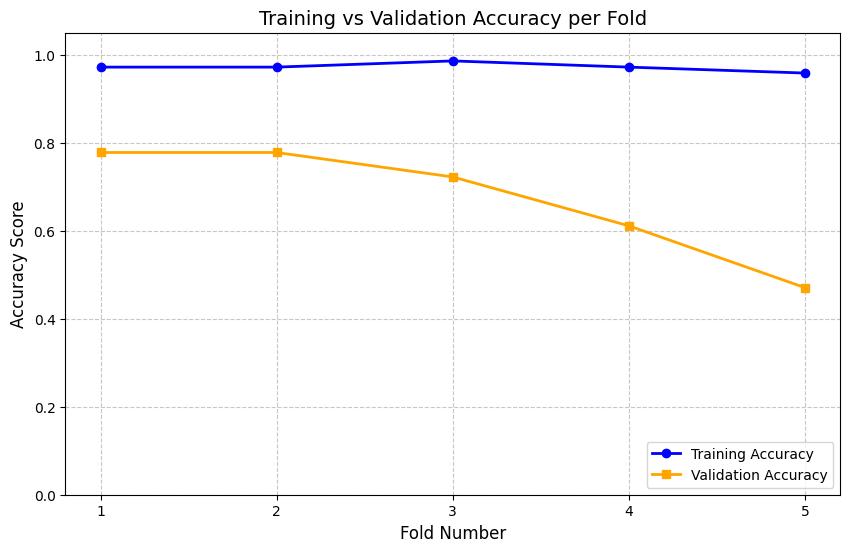

In [10]:
import matplotlib.pyplot as plt


folds = range(1, len(cv_train_acc) + 1)

plt.figure(figsize=(10, 6))


plt.plot(folds, cv_train_acc, 'o-', label='Training Accuracy', color='blue', linewidth=2)


plt.plot(folds, cv_val_acc, 's-', label='Validation Accuracy', color='orange', linewidth=2)


plt.title('Training vs Validation Accuracy per Fold', fontsize=14)
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('Accuracy Score', fontsize=12)
plt.xticks(folds) 
plt.ylim(0, 1.05) 
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right')



In [11]:
#final Test Evaluation
tab_scaler = StandardScaler()
X_tab_trainval_scaled = tab_scaler.fit_transform(X_tab_trainval)
X_tab_test_scaled     = tab_scaler.transform(X_tab_test)

if X_img_trainval.shape[-1] == 1:
    print("Converting TrainVal images to 3 channels...")
    X_img_trainval = np.repeat(X_img_trainval, 3, axis=-1)

if X_img_test.shape[-1] == 1:
    print("Converting Test images to 3 channels...")
    X_img_test = np.repeat(X_img_test, 3, axis=-1)
    
trainval_cnn = cnn_feature_extractor.predict(preprocess_input(X_img_trainval * 255.0), verbose=0)
test_cnn     = cnn_feature_extractor.predict(preprocess_input(X_img_test * 255.0), verbose=0)


X_trainval_comb = np.concatenate([X_tab_trainval_scaled, trainval_cnn], axis=1)
X_test_comb     = np.concatenate([X_tab_test_scaled, test_cnn], axis=1)

#PCA
pca_final = PCA(n_components=0.99)
X_trainval_pca = pca_final.fit_transform(X_trainval_comb)

X_test_pca = pca_final.transform(X_test_comb)

comb_scaler = StandardScaler()
X_trainval_scaled = comb_scaler.fit_transform(X_trainval_pca)
X_test_scaled     = comb_scaler.transform(X_test_pca)


svm_final = SVC(kernel='rbf', C=10, gamma=0.001 ,class_weight='balanced')
svm_final.fit(X_trainval_scaled, y_trainval)

test_pred = svm_final.predict(X_test_scaled)
test_acc = accuracy_score(y_test, test_pred)

test_scores = svm_final.decision_function(X_test_scaled)
fpr_test, tpr_test, _ = roc_curve(y_test, test_scores)
test_auc = auc(fpr_test, tpr_test)

print("\nFinal Test Accuracy:", test_acc)
print("Final Test ROC-AUC:", test_auc)


Converting TrainVal images to 3 channels...
Converting Test images to 3 channels...

Final Test Accuracy: 0.717948717948718
Final Test ROC-AUC: 0.8492063492063493


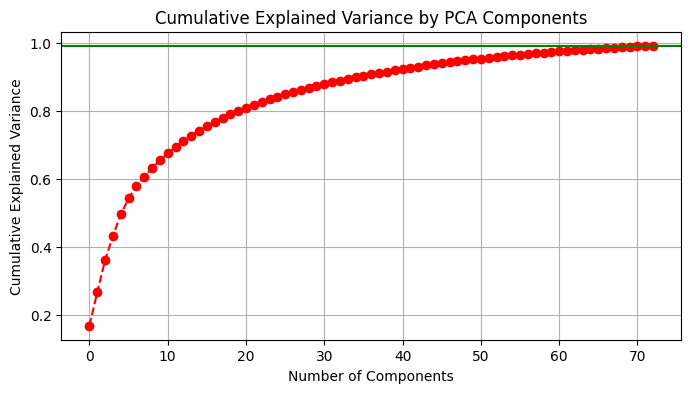

In [12]:
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca_final.explained_variance_ratio_), marker='o', linestyle='--', color='red')
plt.axhline(y=0.99, color='g', linestyle='-')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

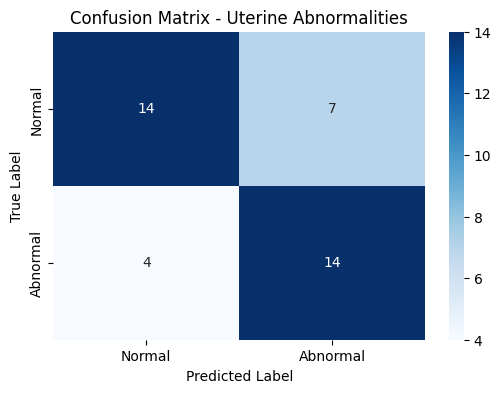

              precision    recall  f1-score   support

      Normal       0.78      0.67      0.72        21
    Abnormal       0.67      0.78      0.72        18

    accuracy                           0.72        39
   macro avg       0.72      0.72      0.72        39
weighted avg       0.73      0.72      0.72        39



In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Generate Matrix
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues' ,xticklabels=["Normal", "Abnormal"],
   yticklabels=["Normal", "Abnormal"])
plt.title("Confusion Matrix - Uterine Abnormalities")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

target_names =['Normal' , 'Abnormal']
print(classification_report(y_test, test_pred , target_names=target_names))